### Checks if I have selected the right `venv` kernel


In [320]:
import sys
print(sys.executable)


c:\Users\Faheem Faizal\Desktop\VSCode Projects\SC2006-Software-Engineering-Project\MLPricePredictor\venv\Scripts\python.exe


### Import the necessary libraries for `EDA` 

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import re
from datetime import datetime


In [322]:
data = pd.read_csv("HDB_resale_prices_from_Jan_2017.csv")  # or your dataset


### For Reproducibility sakes, we are going to make the random.seed constant @ `42`

In [323]:
np.random.seed(42)

### First we will explore the `Data` through these commands

In [324]:
# Display the first few rows of the data
data.head()



,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [325]:
# Display information about data types and non-null counts
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202399 entries, 0 to 202398
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                202399 non-null  object 
 1   town                 202399 non-null  object 
 2   flat_type            202399 non-null  object 
 3   block                202399 non-null  object 
 4   street_name          202399 non-null  object 
 5   storey_range         202399 non-null  object 
 6   floor_area_sqm       202399 non-null  float64
 7   flat_model           202399 non-null  object 
 8   lease_commence_date  202399 non-null  int64  
 9   remaining_lease      202399 non-null  object 
 10  resale_price         202399 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 17.0+ MB


In [326]:
# Get statistical summary of the numeric columns
data.describe()


,floor_area_sqm,lease_commence_date,resale_price
count,202399.000000,202399.000000,2.023990e+05
mean,96.937723,1996.242012,5.116882e+05
std,24.029455,14.185842,1.795631e+05
min,31.000000,1966.000000,1.400000e+05
25%,82.000000,1985.000000,3.800000e+05
50%,93.000000,1996.000000,4.800000e+05
75%,112.000000,2011.000000,6.130000e+05
max,366.700000,2021.000000,1.600000e+06


### Next Step: **Data Cleaning** 



In [327]:
# Check for missing values in each column
print(data.isnull().sum())

# If there are missing values, you can choose to drop them:
data_clean = data.dropna()  # or use data.fillna() to fill missing values

# Verify that missing values are handled
print(data_clean.isnull().sum())


month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64
month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64


### `Step 3`: **Data Preprocessing**
#### Convert Data Types

#### We will now be converting the columns into numeric or datetime types as most of them are stored as text

### 3.1 Month (YYYY-MM) → datetime

In [328]:
data['month'] = pd.to_datetime(data['month'], format='%Y-%m', errors='coerce')

# Convert the 'month' column to a numeric feature representing months since January 2017
data['months_since'] = ((data['month'] - pd.Timestamp("2017-01-01")).dt.days) / 30


### 3.2 Town → Categorical


In [329]:
data['town'] = data['town'].astype('category')

#Town is a place name (e.g., “TAMPINES”), 
# so we store it as a category for memory efficiency and easy encoding later.

### 3.3 Flat Type → Categorical

In [330]:
data['flat_type'] = data['flat_type'].astype('category')

# Values like “3 ROOM,” “4 ROOM,” etc. are discrete categories.
# You can later convert them to numeric if needed for ML (one-hot or label encode).

### 3.4 Block & Street Name → Possibly Keep as Text or Drop
### Block (e.g., “123,” “456A”): Usually text. Might not be used in modeling, but can keep for reference.
### Street Name (e.g., “TAMPINES ST 21”): Usually text. Possibly combine with block or town if needed.

### **3.5 Storey Range → Parse Range**
#### Values like “10 TO 12” can be parsed to get the average floor:

In [331]:
def parse_storey_range(range_str):
    # e.g., "10 TO 12" -> (10+12)/2 = 11
    # If there's no "TO", handle single storey
    parts = range_str.split(" TO ")
    if len(parts) == 2:
        low = int(parts[0])
        high = int(parts[1])
        return (low + high) / 2
    else:
        # If it's a single value or missing
        try:
            return float(parts[0])
        except:
            return np.nan

data['storey_avg'] = data['storey_range'].apply(parse_storey_range)


#Explanation:
# This function splits the string on “ TO ” and averages the two floors.
# If there’s only one floor, we just convert it to float.


### 3.6 Floor Area Sqm → Numeric

In [332]:
data['floor_area_sqm'] = pd.to_numeric(data['floor_area_sqm'], errors='coerce')

# Converting to numeric so we can do math on it.
# errors='coerce' will turn invalid values into NaN.

### 3.7 Flat Model → Categorical

In [333]:
data['flat_model'] = data['flat_model'].astype('category')


### 3.8 Lease Commence Date → Numeric (Year)

In [334]:
data['lease_commence_date'] = pd.to_numeric(data['lease_commence_date'], errors='coerce')


### 3.9 Remaining Lease → Numeric (Years)
### If the format is something like “64 years 05 months,” parse it:

In [335]:
import re

def parse_remaining_lease(lease_str):
    # Example: "64 years 05 months"
    # Use regex to extract years and months
    pattern = r'(\d+)\s+years?\s+(\d+)\s+months?'
    match = re.search(pattern, lease_str.lower())
    if match:
        years = int(match.group(1))
        months = int(match.group(2))
        return years + months/12.0
    else:
        # If it doesn't match or is empty, return NaN
        return np.nan

data['remaining_lease'] = data['remaining_lease'].apply(parse_remaining_lease)

# We convert the textual representation (e.g., “64 years 05 months”) to a float in years (64.4167).
# This is helpful for ML models that need numeric features.


# To Verify the Conversion
print(data['remaining_lease'].head())
data['remaining_lease'].dtype


0    61.333333
1    60.583333
2    62.416667
3    62.083333
4    62.416667
Name: remaining_lease, dtype: float64


dtype('float64')

### 3.10 Resale Price → Numeric

In [336]:
data['resale_price'] = pd.to_numeric(data['resale_price'], errors='coerce')


# If it’s stored as text, we convert it to numeric.
# We can then do statistical analysis or ML on it as our target variable.

### 3.11 Drop Unneeded Columns

In [337]:
data = data.drop(columns=['storey_range', 'block', 'street_name', 'lease_commence_date'])

# If storey_range, block, street_name, and lease_commence_date, you can drop them.

### `Step 4` **Quick Check After Conversions**

In [338]:
# Check conversion results
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202399 entries, 0 to 202398
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   month            202399 non-null  datetime64[ns]
 1   town             202399 non-null  category      
 2   flat_type        202399 non-null  category      
 3   floor_area_sqm   202399 non-null  float64       
 4   flat_model       202399 non-null  category      
 5   remaining_lease  185757 non-null  float64       
 6   resale_price     202399 non-null  float64       
 7   months_since     202399 non-null  float64       
 8   storey_avg       202399 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(5)
memory usage: 9.8 MB


### ``Step 5``: **Exploratory Data Analysis (EDA)**

### A. Summary Statistics

In [339]:
# Summary statistics for numeric columns
print(data[['floor_area_sqm', 'resale_price', 'remaining_lease', 'month']].describe())


# We see the mean, std, min, max for these numeric columns.

       floor_area_sqm  resale_price  remaining_lease  \
count   202399.000000  2.023990e+05    185757.000000   
mean        96.937723  5.116882e+05        74.404412   
min         31.000000  1.400000e+05        40.083333   
25%         82.000000  3.800000e+05        62.750000   
50%         93.000000  4.800000e+05        74.250000   
75%        112.000000  6.130000e+05        88.500000   
max        366.700000  1.600000e+06        97.750000   
std         24.029455  1.795631e+05        14.095818   

                               month  
count                         202399  
mean   2021-04-22 07:26:52.306384896  
min              2017-01-01 00:00:00  
25%              2019-06-01 00:00:00  
50%              2021-06-01 00:00:00  
75%              2023-04-01 00:00:00  
max              2025-03-01 00:00:00  
std                              NaN  


### 5.2 Distribution Plots

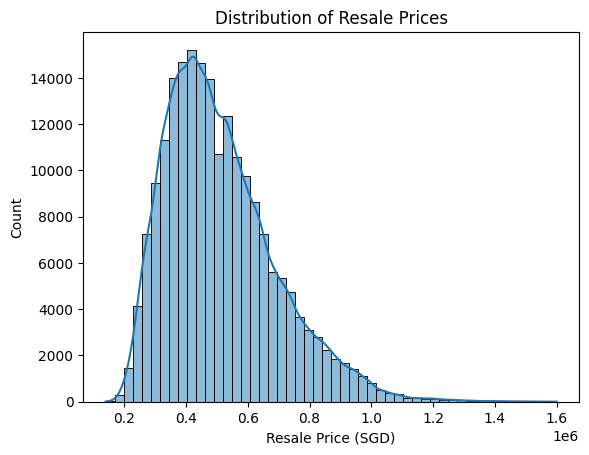

In [340]:
# Distribution of resale prices
sb.histplot(data['resale_price'], bins=50, kde=True)
plt.title("Distribution of Resale Prices")
plt.xlabel("Resale Price (SGD)")
plt.ylabel("Count")
plt.show()


### 5.3 Relationship Plots

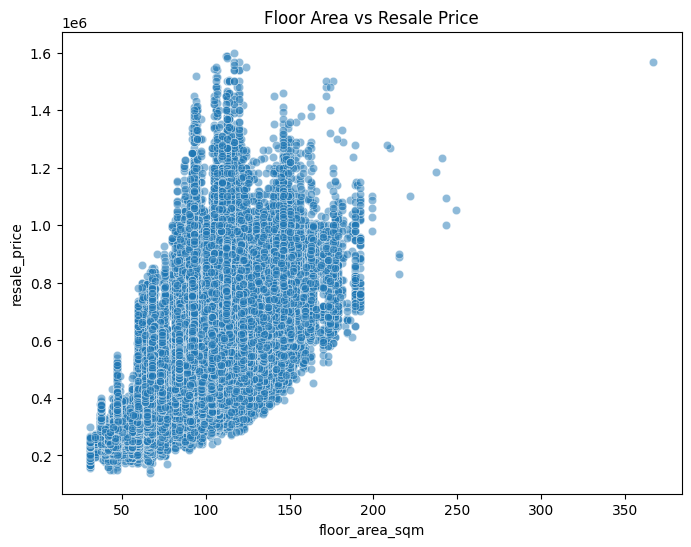

In [341]:
# Scatter plot: Floor Area vs. Resale Price
plt.figure(figsize=(8,6))
sb.scatterplot(x='floor_area_sqm', y='resale_price', data=data, alpha=0.5)
plt.title("Floor Area vs Resale Price")
plt.show()

# This reveals if a larger floor area 
# typically correlates with a higher resale price.

### 5.4 Time-Series or Month Analysis

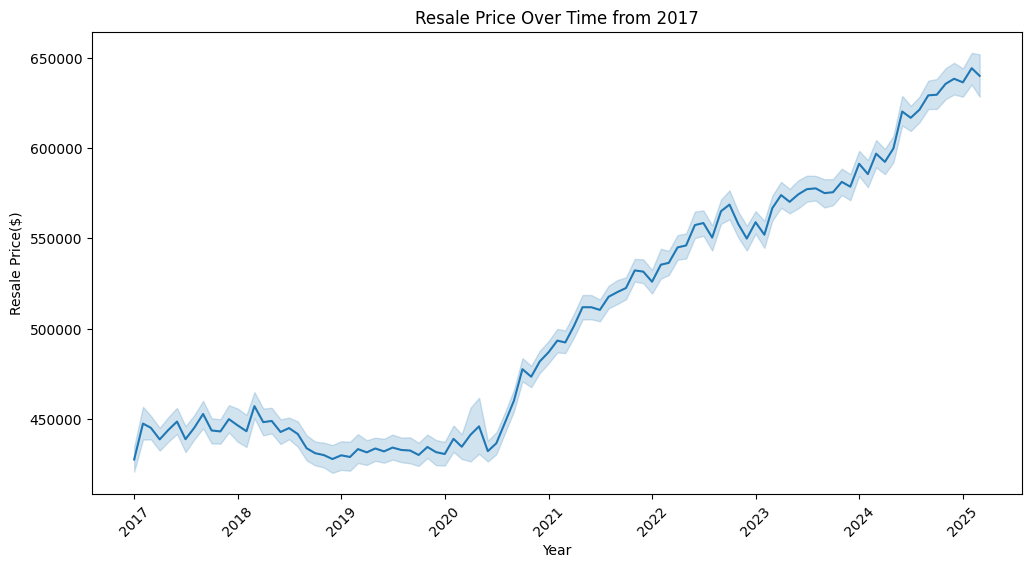

In [342]:
# If 'Month' is a datetime, let's see how prices change over time
data_sorted = data.sort_values(by='month')
plt.figure(figsize=(12,6))
sb.lineplot(x='month', y='resale_price', data=data_sorted)
plt.xticks(rotation=45)
plt.title("Resale Price Over Time from 2017")
plt.xlabel("Year")
plt.ylabel("Resale Price($)")
plt.show()

#This shows how prices trend from 2017 onward.



### `Step 6`: Data Preparation for Modeling 


### 6.1 Handling Missing Values

In [343]:
# Check for missing values and drop rows if necessary
print(data.isnull().sum())
data_clean = data.dropna()

print("After dropping missing values:")
print(data_clean.isnull().sum())

# We drop rows with missing values for simplicity.
# Alternatively, you could fill them with a mean/median if dropping too many rows is an issue.


month                  0
town                   0
flat_type              0
floor_area_sqm         0
flat_model             0
remaining_lease    16642
resale_price           0
months_since           0
storey_avg             0
dtype: int64
After dropping missing values:
month              0
town               0
flat_type          0
floor_area_sqm     0
flat_model         0
remaining_lease    0
resale_price       0
months_since       0
storey_avg         0
dtype: int64


### 6.2 Selecting Features and Target

In [344]:
#We’ll use these features:

# floor_area_sqm (numeric)
# remaining_lease (numeric)
# months_since (numeric, representing time)
# flat_type, flat_model, town (categorical)

# One-hot encode categorical features
data_encoded = pd.get_dummies(data_clean, columns=['flat_type', 'flat_model', 'town'], drop_first=True)
data_encoded.head()


# One-hot encoding transforms categorical variables into a format that can be provided to ML algorithms.
# drop_first=True avoids multicollinearity by dropping one dummy variable from each categorical feature.

# target = data_clean['resale_price']

# # Display first few rows of features
# features.head()

# # We choose features that we believe influence the resale price.
# # You can experiment with other features later.

,month,floor_area_sqm,remaining_lease,resale_price,months_since,storey_avg,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,2017-01-01,44.0,61.333333,232000.0,0.0,11.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2017-01-01,67.0,60.583333,250000.0,0.0,2.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2017-01-01,67.0,62.416667,262000.0,0.0,2.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2017-01-01,68.0,62.083333,265000.0,0.0,5.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2017-01-01,67.0,62.416667,265000.0,0.0,2.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


### 6.3 Define Features (X) and Target (Y)



### **Features:**

### `floor_area_sqm (numeric)`
#### Larger floor areas typically command higher prices.

### `remaining_lease (numeric)`
#### Units with more years left on their lease are often more expensive.

### `months_since (numeric)`
#### A time-based feature representing how many months have passed since a baseline date (e.g., Jan 2017). This captures market trends over time.

### `storey_avg (numeric)`
#### The average storey from “storey_range” (e.g., 10.5 means between 10th and 11th floor). This accounts for the higher-level → higher price insight.

### `flat_type (categorical → one-hot encoded)`
#### e.g., 3-ROOM, 4-ROOM, EXECUTIVE, etc. Different flat types have different average prices.

### `flat_model (categorical → one-hot encoded)`
#### e.g., New Generation, Model A, DBSS, etc. Some models are more valuable.

### `town (categorical → one-hot encoded)`
#### Different towns (e.g., TAMPINES, BISHAN, ANG MO KIO) vary in desirability and price.

### **Why These Features?**
`floor_area_sqm:` Clear relationship—>bigger flats cost more.

`remaining_lease:` Flats with more lease left typically sell for higher.

`months_since:` Captures overall market inflation or deflation over time.

`storey_avg:` Graph suggests higher floors fetch higher resale prices.

`flat_type, flat_model`: Each combination has typical price ranges.

`town`: Location is a major factor in property value.


In [345]:
# Define features (which now includes 'months_since')
feature_columns = ['floor_area_sqm', 'remaining_lease', 'months_since', 'storey_avg'] + [col for col in data_encoded.columns if col.startswith('flat_type_') or col.startswith('flat_model_') or col.startswith('town_')]


X = data_encoded[feature_columns]
Y = data_encoded['resale_price']

print("Features shape:", X.shape)
print("Target shape:", Y.shape)



# #We specify which columns to use as features and which column is our target.
# The final feature set includes numeric features and the dummy variables from categorical ones.


Features shape: (185757, 55)
Target shape: (185757,)


In [346]:
print(data_encoded.columns)


Index(['month', 'floor_area_sqm', 'remaining_lease', 'resale_price',
       'months_since', 'storey_avg', 'flat_type_2 ROOM', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_type_MULTI-GENERATION', 'flat_model_3Gen',
       'flat_model_Adjoined flat', 'flat_model_Apartment', 'flat_model_DBSS',
       'flat_model_Improved', 'flat_model_Improved-Maisonette',
       'flat_model_Maisonette', 'flat_model_Model A',
       'flat_model_Model A-Maisonette', 'flat_model_Model A2',
       'flat_model_Multi Generation', 'flat_model_New Generation',
       'flat_model_Premium Apartment', 'flat_model_Premium Apartment Loft',
       'flat_model_Premium Maisonette', 'flat_model_Simplified',
       'flat_model_Standard', 'flat_model_Terrace', 'flat_model_Type S1',
       'flat_model_Type S2', 'town_BEDOK', 'town_BISHAN', 'town_BUKIT BATOK',
       'town_BUKIT MERAH', 'town_BUKIT PANJANG', 'town_BUKIT TIMAH',
       'town_CENTRAL AREA', 'town_CHOA C

### 6.4 Scale the Features 

In [347]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Why Scale?
# Equal Contribution:
# When features have vastly different scales (e.g., floor area in tens or hundreds versus a binary encoded feature), the larger-scale features can dominate the learning process. Scaling ensures that each feature contributes equally to the model.

# Improved Convergence:
# Many machine learning algorithms, especially those that use gradient descent (like linear regression with regularization, neural networks, etc.) or distance-based algorithms (like k-nearest neighbors or support vector machines), converge faster and more reliably when the data is normalized.

# Avoiding Numerical Instability:
# When features are on different scales, it can lead to numerical instability or issues during computation. Scaling helps maintain stability during training.

# Better Performance:
# Some models are sensitive to the range of data. Standardizing features can often improve the model's performance and accuracy.

### `Step 7`: Training the Models


### 7.1 Split Data into `Training` and `Test` Sets *(80-20 Split)*

In [348]:
# We split the data so that we can train the model on one subset and test it on unseen data.
from sklearn.model_selection import train_test_split

# Split data: 80% training and 20% testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

# We use train_test_split to separate the scaled feature matrix (X_scaled) and target (Y) into training and testing sets.
# The test_size=0.2 argument means 20% of the data is used for testing.
# random_state = 42 ensures reproducibility.


Training set shape: (148605, 55)
Test set shape: (37152, 55)


### 7.2 Train a Baseline Model (Linear Regression)

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred_lr = lr_model.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, r2_score

mse_lr = mean_squared_error(Y_test, Y_pred_lr)
r2_lr = r2_score(Y_test, Y_pred_lr)
print("Linear Regression MSE:", mse_lr)
print("Linear Regression R^2:", r2_lr)
print("Linear Regression R(Coefficient of Determination):", r2_lr ** 0.5)


Linear Regression MSE: 4387049045.878127
Linear Regression RMSE: 66234.80237668206
Linear Regression R^2: 0.8637060431432892
Linear Regression R(Coefficient of Determination): 0.9293578660254022


### 7.3 Visualize Linear Regression Predictions

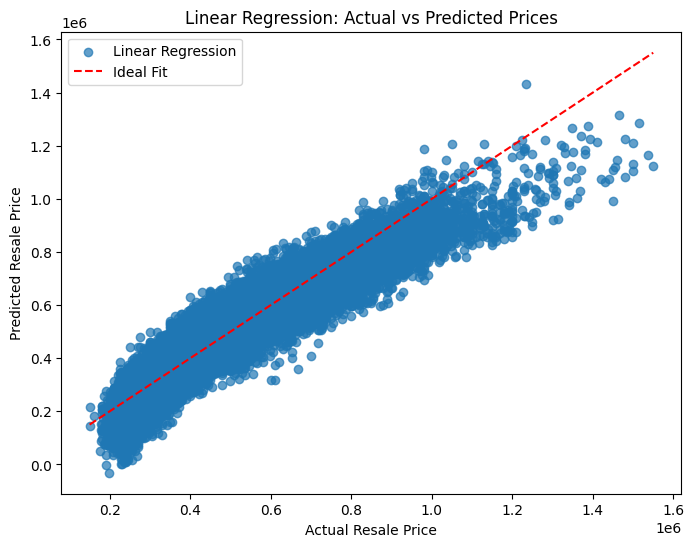

In [350]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(Y_test, Y_pred_lr, alpha=0.7, label='Linear Regression')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.show()


# We plot the actual resale prices against the predicted prices.
# The red dashed line represents perfect predictions (where predicted = actual).
# This plot helps you visually assess how close the predictions are to the true values.

### 7.4 Train an Advanced Model (Random Forest Regression)

In [353]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)
print("Random Forest MSE:", mse_rf)
print("Random Forest RMSE:", mse_rf ** 0.5)
print("Random Forest R^2:", r2_rf)
print("Random Forest R (Coefficient of Determination):", r2_rf ** 0.5)


Random Forest MSE: 1453145731.1457262
Random Forest RMSE: 38120.148624391884
Random Forest R^2: 0.9548546233433673
Random Forest R (Coefficient of Determination): 0.9771666302854224


### 7.5 Visualize Random Forest Predictions

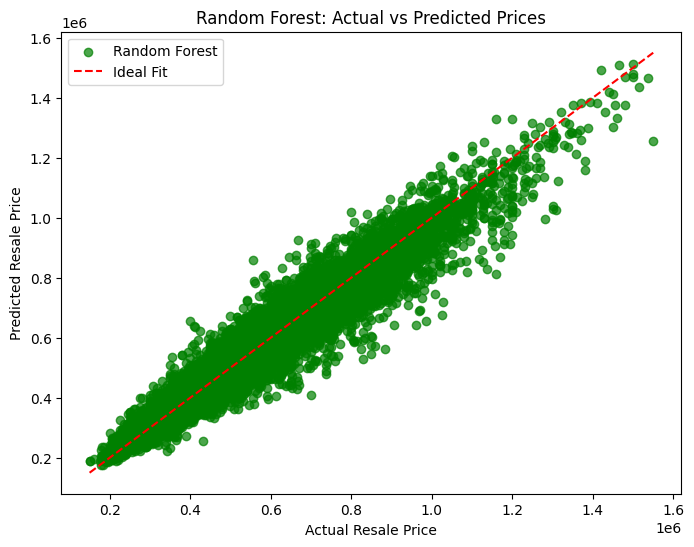

In [352]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test, Y_pred_rf, alpha=0.7, color='green', label='Random Forest')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("Random Forest: Actual vs Predicted Prices")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', label='Ideal Fit')
plt.legend()
plt.show()



### `Step 8`: Understanding the Model Results


A. **Linear Regression**

MSE: 483,704,945.878127

Meaning: On average, the squared difference between predicted resale prices and actual resale prices is about 483.7 million (in squared currency units).
Interpretation: The lower the MSE, the better the model fits your data. While 483 million sounds large, keep in mind that resale prices might be in the hundreds of thousands to over a million. The absolute scale of MSE depends on your target variable’s scale.

R²: 0.863760841342892

Meaning: About 86% of the variance in resale prices is explained by your features (floor area, lease, month, etc.).
Interpretation: An R² of 0.86 is quite good for many real-world applications—suggesting the linear model does a decent job. However, it might leave room for improvement.

Additional “R” or “Coefficient of Determination”: 0.9293578660254022

Likely this is the correlation (the square root of R²) between predicted and actual. If R² is ~0.86, then √0.86 ≈ 0.93, which lines up with your “Coefficient of Determination.”
Typically, R² is the “coefficient of determination,” but some code might be computing correlation (r) as well.

B. **Random Forest Regression**

MSE: 145,314,573.1457262

Meaning: The squared difference between predicted and actual prices averages ~145.3 million, which is significantly lower than the linear model’s ~483 million MSE.
Interpretation: A much better fit in terms of raw error.

R²: 0.9548462323433673

Meaning: About 95.48% of the variance in resale prices is explained by the model—indicating a stronger relationship and better predictive capability than Linear Regression.
R (Coefficient of Determination): 0.977...

If you see an R of `~0.977`, that’s likely the correlation between predicted and actual (the square root of R² = √0.9548 ≈ 0.977).
Interpretation: Very high correlation, indicating the model’s predictions track actual values closely.